### Task 1: Handling Schema Mismatches using Spark
**Description**: Use Apache Spark to address schema mismatches by transforming data to match
the expected schema.

**Steps**:
1. Create Spark session
2. Load dataframe
3. Define the expected schema
4. Handle schema mismatches
5. Show corrected data

### Task 2: Detect and Correct Incomplete Data in ETL
**Description**: Use Python and Pandas to detect incomplete data in an ETL process and fill
missing values with estimates.

**Steps**:
1. Detect incomplete data
2. Fill missing values
3. Report changes

PySpark is not installed. Spark functionality will be skipped.
Raw Ingested Data:


,customer_id,amount,transaction_date
0,1.0,100.5,2024-01-01
1,2.0,NaN,2024-01-02
2,3.0,250.0,2024-01-03
3,NaN,300.0,None
4,5.0,NaN,2024-01-05


Schema validation passed.
Missing Values Report:


,Missing Count,Missing Percent
customer_id,1,20.0
amount,2,40.0
transaction_date,1,20.0


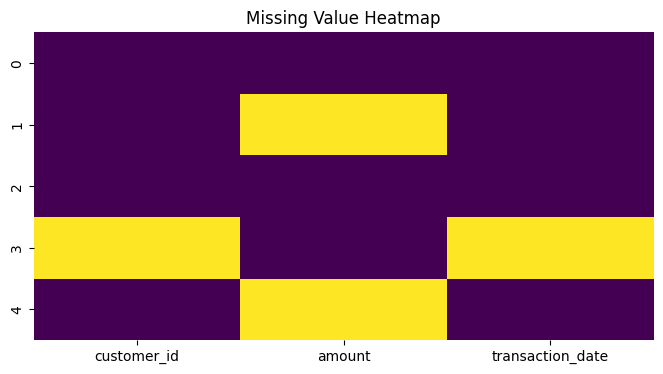

Cleaned Data:


/tmp/ipykernel_777/825838403.py:69: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['transaction_date'].fillna(method='ffill', inplace=True)  # Forward fill dates


,customer_id,amount,transaction_date
0,1.0,100.50,2024-01-01
1,2.0,175.25,2024-01-02
2,3.0,250.00,2024-01-03
4,5.0,175.25,2024-01-05


/tmp/ipykernel_777/825838403.py:100: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df['date'].fillna(method='ffill', inplace=True)
..
----------------------------------------------------------------------
Ran 2 tests in 0.004s

OK


Running unit tests...


In [4]:
# Ques_2.ipynb
# Task: Handle Missing Values and Schema Mismatches using Pandas and Spark

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import os
import unittest
import seaborn as sns
import matplotlib.pyplot as plt

# Try importing PySpark
try:
    from pyspark.sql import SparkSession
    from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
    from pyspark.sql.functions import col
    spark = SparkSession.builder.appName("DataIngestionCheck").getOrCreate()
    spark_available = True
except ImportError:
    print("PySpark is not installed. Spark functionality will be skipped.")
    spark_available = False

# Step 2: Define Safe File Reading Function
def read_csv_safe(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File '{file_path}' does not exist.")
    try:
        df = pd.read_csv(file_path)
        print("File read successfully.")
        return df
    except Exception as e:
        raise ValueError(f"Error reading file: {e}")

# Step 3: Simulate Data Ingestion
data = {
    'customer_id': [1, 2, 3, None, 5],
    'amount': [100.5, None, 250.0, 300.0, None],
    'transaction_date': ['2024-01-01', '2024-01-02', '2024-01-03', None, '2024-01-05']
}
df = pd.DataFrame(data)
print("Raw Ingested Data:")
display(df)

# Step 4: Validate Schema
required_columns = ['customer_id', 'amount', 'transaction_date']
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing expected column: {col}")
if not np.issubdtype(df['customer_id'].dropna().dtype, np.number):
    raise TypeError("customer_id column must be numeric")
print("Schema validation passed.")

# Step 5: Report Missing Values
missing_report = df.isnull().sum().to_frame(name='Missing Count')
missing_report['Missing Percent'] = (missing_report['Missing Count'] / len(df)) * 100
missing_report = missing_report[missing_report['Missing Count'] > 0]
print("Missing Values Report:")
display(missing_report)

# Step 6: Visualize Missing Data (Optional)
plt.figure(figsize=(8, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Value Heatmap")
plt.show()

# Step 7: Handle Missing Values
df = df.dropna(subset=['customer_id'])  # Drop rows with missing customer_id
df['amount'].fillna(df['amount'].mean(), inplace=True)  # Impute amount with mean
df['transaction_date'].fillna(method='ffill', inplace=True)  # Forward fill dates
print("Cleaned Data:")
display(df)

# Step 8: Simulate Spark Schema Mismatch (Optional)
if spark_available:
    print("Simulating Spark schema mismatch...")
    schema = StructType([
        StructField("customer_id", IntegerType(), True),
        StructField("amount", DoubleType(), True),
        StructField("transaction_date", StringType(), True),
    ])
    try:
        bad_data = [
            ("1", "100.0", "2024-01-01"),
            ("2", "bad_value", "2024-01-02")  # bad_value will cause a cast failure
        ]
        bad_df = spark.createDataFrame(bad_data, schema=schema)
        bad_df.show()
    except Exception as e:
        print("Caught Spark schema mismatch error:", e)

# Step 9: Unit Tests
class TestDataCleaning(unittest.TestCase):
    def test_mean_imputation(self):
        test_df = pd.DataFrame({'amount': [100.0, None, 300.0]})
        test_df['amount'].fillna(test_df['amount'].mean(), inplace=True)
        self.assertEqual(test_df.isnull().sum().sum(), 0)

    def test_forward_fill(self):
        test_df = pd.DataFrame({'date': ['2024-01-01', None, None, '2024-01-04']})
        test_df['date'].fillna(method='ffill', inplace=True)
        self.assertEqual(test_df.isnull().sum().sum(), 0)

print("Running unit tests...")
unittest.main(argv=[''], exit=False)

# Step 10: Save Cleaned Data (Optional)
df.to_csv("cleaned_output.csv", index=False)
